In [ ]:
!pip install fcapy
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
import torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git|

In [ ]:
!pip install bitarray==2.7.5

# Import libs

In [3]:
import numpy as np
import pandas as pd

In [4]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [5]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [6]:
import neural_lib62 as nl

# Pipeline

# Step 0. Binarize the data

First of all, we will use binarization from 3 task of HW3

In [47]:
import seaborn as sns
import pandas as pd

titanic = sns.load_dataset('titanic')
titanic = titanic.dropna(subset=['age', 'embarked'])

# Dichotomic Scale for 'Sex'
titanic['Is Male'] = (titanic['sex'] == 'male').astype(int)
titanic['Not Is Male'] = (titanic['sex'] != 'male').astype(int)

# Nominal Scale for 'ticket class'
titanic = pd.get_dummies(titanic, columns=['pclass'], prefix='pclass')
# Inter-ordinal scale for Fare
titanic['Age_≤12'] = (titanic['age'] <= 12).astype(int)
titanic['Age_≤19'] = (titanic['age'] <= 19).astype(int)
titanic['Age_≤60'] = (titanic['age'] <= 60).astype(int)
titanic['Age_≥13'] = (titanic['age'] >= 13).astype(int)
titanic['Age_≥20'] = (titanic['age'] >= 20).astype(int)
titanic['Age_≥61'] = (titanic['age'] >= 61).astype(int)

# Inter-ordinal scale for Fare
titanic['Fare_≤7.91'] = (titanic['fare'] <= 7.91).astype(int)
titanic['Fare_≤14.454'] = (titanic['fare'] <= 14.454).astype(int)
titanic['Fare_≤31'] = (titanic['fare'] <= 31).astype(int)
titanic['Fare_≥7.92'] = (titanic['fare'] >= 7.92).astype(int)
titanic['Fare_≥14.455'] = (titanic['fare'] >= 14.455).astype(int)
titanic['Fare_≥31.01'] = (titanic['fare'] >= 31.01).astype(int)
# Inter-ordinal scale for SibSp
titanic['SibSp_≥1'] = (titanic['sibsp'] >= 1).astype(int)
titanic['SibSp_≥2'] = (titanic['sibsp'] >= 2).astype(int)
titanic['SibSp_≥3'] = (titanic['sibsp'] >= 3).astype(int)
titanic['SibSp_≤1'] = (titanic['sibsp'] <= 1).astype(int)
titanic['SibSp_≤2'] = (titanic['sibsp'] <= 2).astype(int)
titanic['SibSp_≤3'] = (titanic['sibsp'] <= 3).astype(int)

# Inter-ordinal scale for Parch
titanic['Parch_≥1'] = (titanic['parch'] >= 1).astype(int)
titanic['Parch_≥2'] = (titanic['parch'] >= 2).astype(int)
titanic['Parch_≥3'] = (titanic['parch'] >= 3).astype(int)
titanic['Parch_≤1'] = (titanic['parch'] <= 1).astype(int)
titanic['Parch_≤2'] = (titanic['parch'] <= 2).astype(int)
titanic['Parch_≤3'] = (titanic['parch'] <= 3).astype(int)


#drop binarized features and not used
titanic=titanic.drop(columns=['fare','class','who','parch','adult_male','deck','embark_town','alive','alone',
                            'sex','age','sibsp','embarked' ])
titanic = titanic.astype(bool)

print(titanic.head())


   survived  Is Male  Not Is Male  pclass_1  pclass_2  pclass_3  Age_≤12  \
0     False     True        False     False     False      True    False   
1      True    False         True      True     False     False    False   
2      True    False         True     False     False      True    False   
3      True    False         True      True     False     False    False   
4     False     True        False     False     False      True    False   

   Age_≤19  Age_≤60  Age_≥13  ...  SibSp_≥3  SibSp_≤1  SibSp_≤2  SibSp_≤3  \
0    False     True     True  ...     False      True      True      True   
1    False     True     True  ...     False      True      True      True   
2    False     True     True  ...     False      True      True      True   
3    False     True     True  ...     False      True      True      True   
4    False     True     True  ...     False      True      True      True   

   Parch_≥1  Parch_≥2  Parch_≥3  Parch_≤1  Parch_≤2  Parch_≤3  
0     False     

In [48]:
df_bin = titanic[:25]  # Skip this part as the data is already binary

Split the data to train and test

In [49]:

y_feat = 'survived'

# Split the dataset into train and test sets
df_test = df_bin.sample(frac=0.2, random_state=42)  # 20% test set
df_train = df_bin.drop(df_test.index)

# Separate features and target
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [50]:
# Ensure the index of X_train is of type str
X_train.index = X_train.index.astype(str)
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (20 objects, 29 attributes, 292 connections)
  |Is Male|Not Is Male|pclass_1|pclass_2|pclass_3|...|Parch_≥2|Parch_≥3|Parch_≤1|Parch_≤2|Parch_≤3|
1 |       |          X|       X|        |        |...|        |        |       X|       X|       X|
2 |       |          X|        |        |       X|...|        |        |       X|       X|       X|
3 |       |          X|       X|        |        |...|        |        |       X|       X|       X|
4 |      X|           |        |        |       X|...|        |        |       X|       X|       X|
6 |      X|           |       X|        |        |...|        |        |       X|       X|       X|
7 |      X|           |        |        |       X|...|        |        |       X|       X|       X|
8 |       |          X|        |        |       X|...|       X|        |        |       X|       X|
10|       |          X|        |        |       X|...|        |        |       X|       X|       X|
11|       |          X|       X|        |

In [51]:
L = ConceptLattice.from_context(K_train, algorithm = 'Sofia', is_monotone=True) # algorithm = 'Sofia'
len(L)

371

In [ ]:
for c in L:
  print(c.extent, c.intent)


Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(100, 171): frozenset({270}), (105, 195): frozenset({198}), (120, 180): frozenset({160}), (156, 189): frozenset({290}), (174, 217): frozenset({137}), (182, 262): frozenset({353}), (186, 227): frozenset({222}), (193, 236): frozenset({112}), (204, 283): frozenset({111}), (205, 285): frozenset({214}), (213, 307): frozenset({313}), (228, 265): frozenset({274}), (229, 266): frozenset({168}), (241, 277): frozenset({289}), (275, 307): frozenset({354}), (342, 365): frozenset({319}), (345, 366): frozenset({351})}


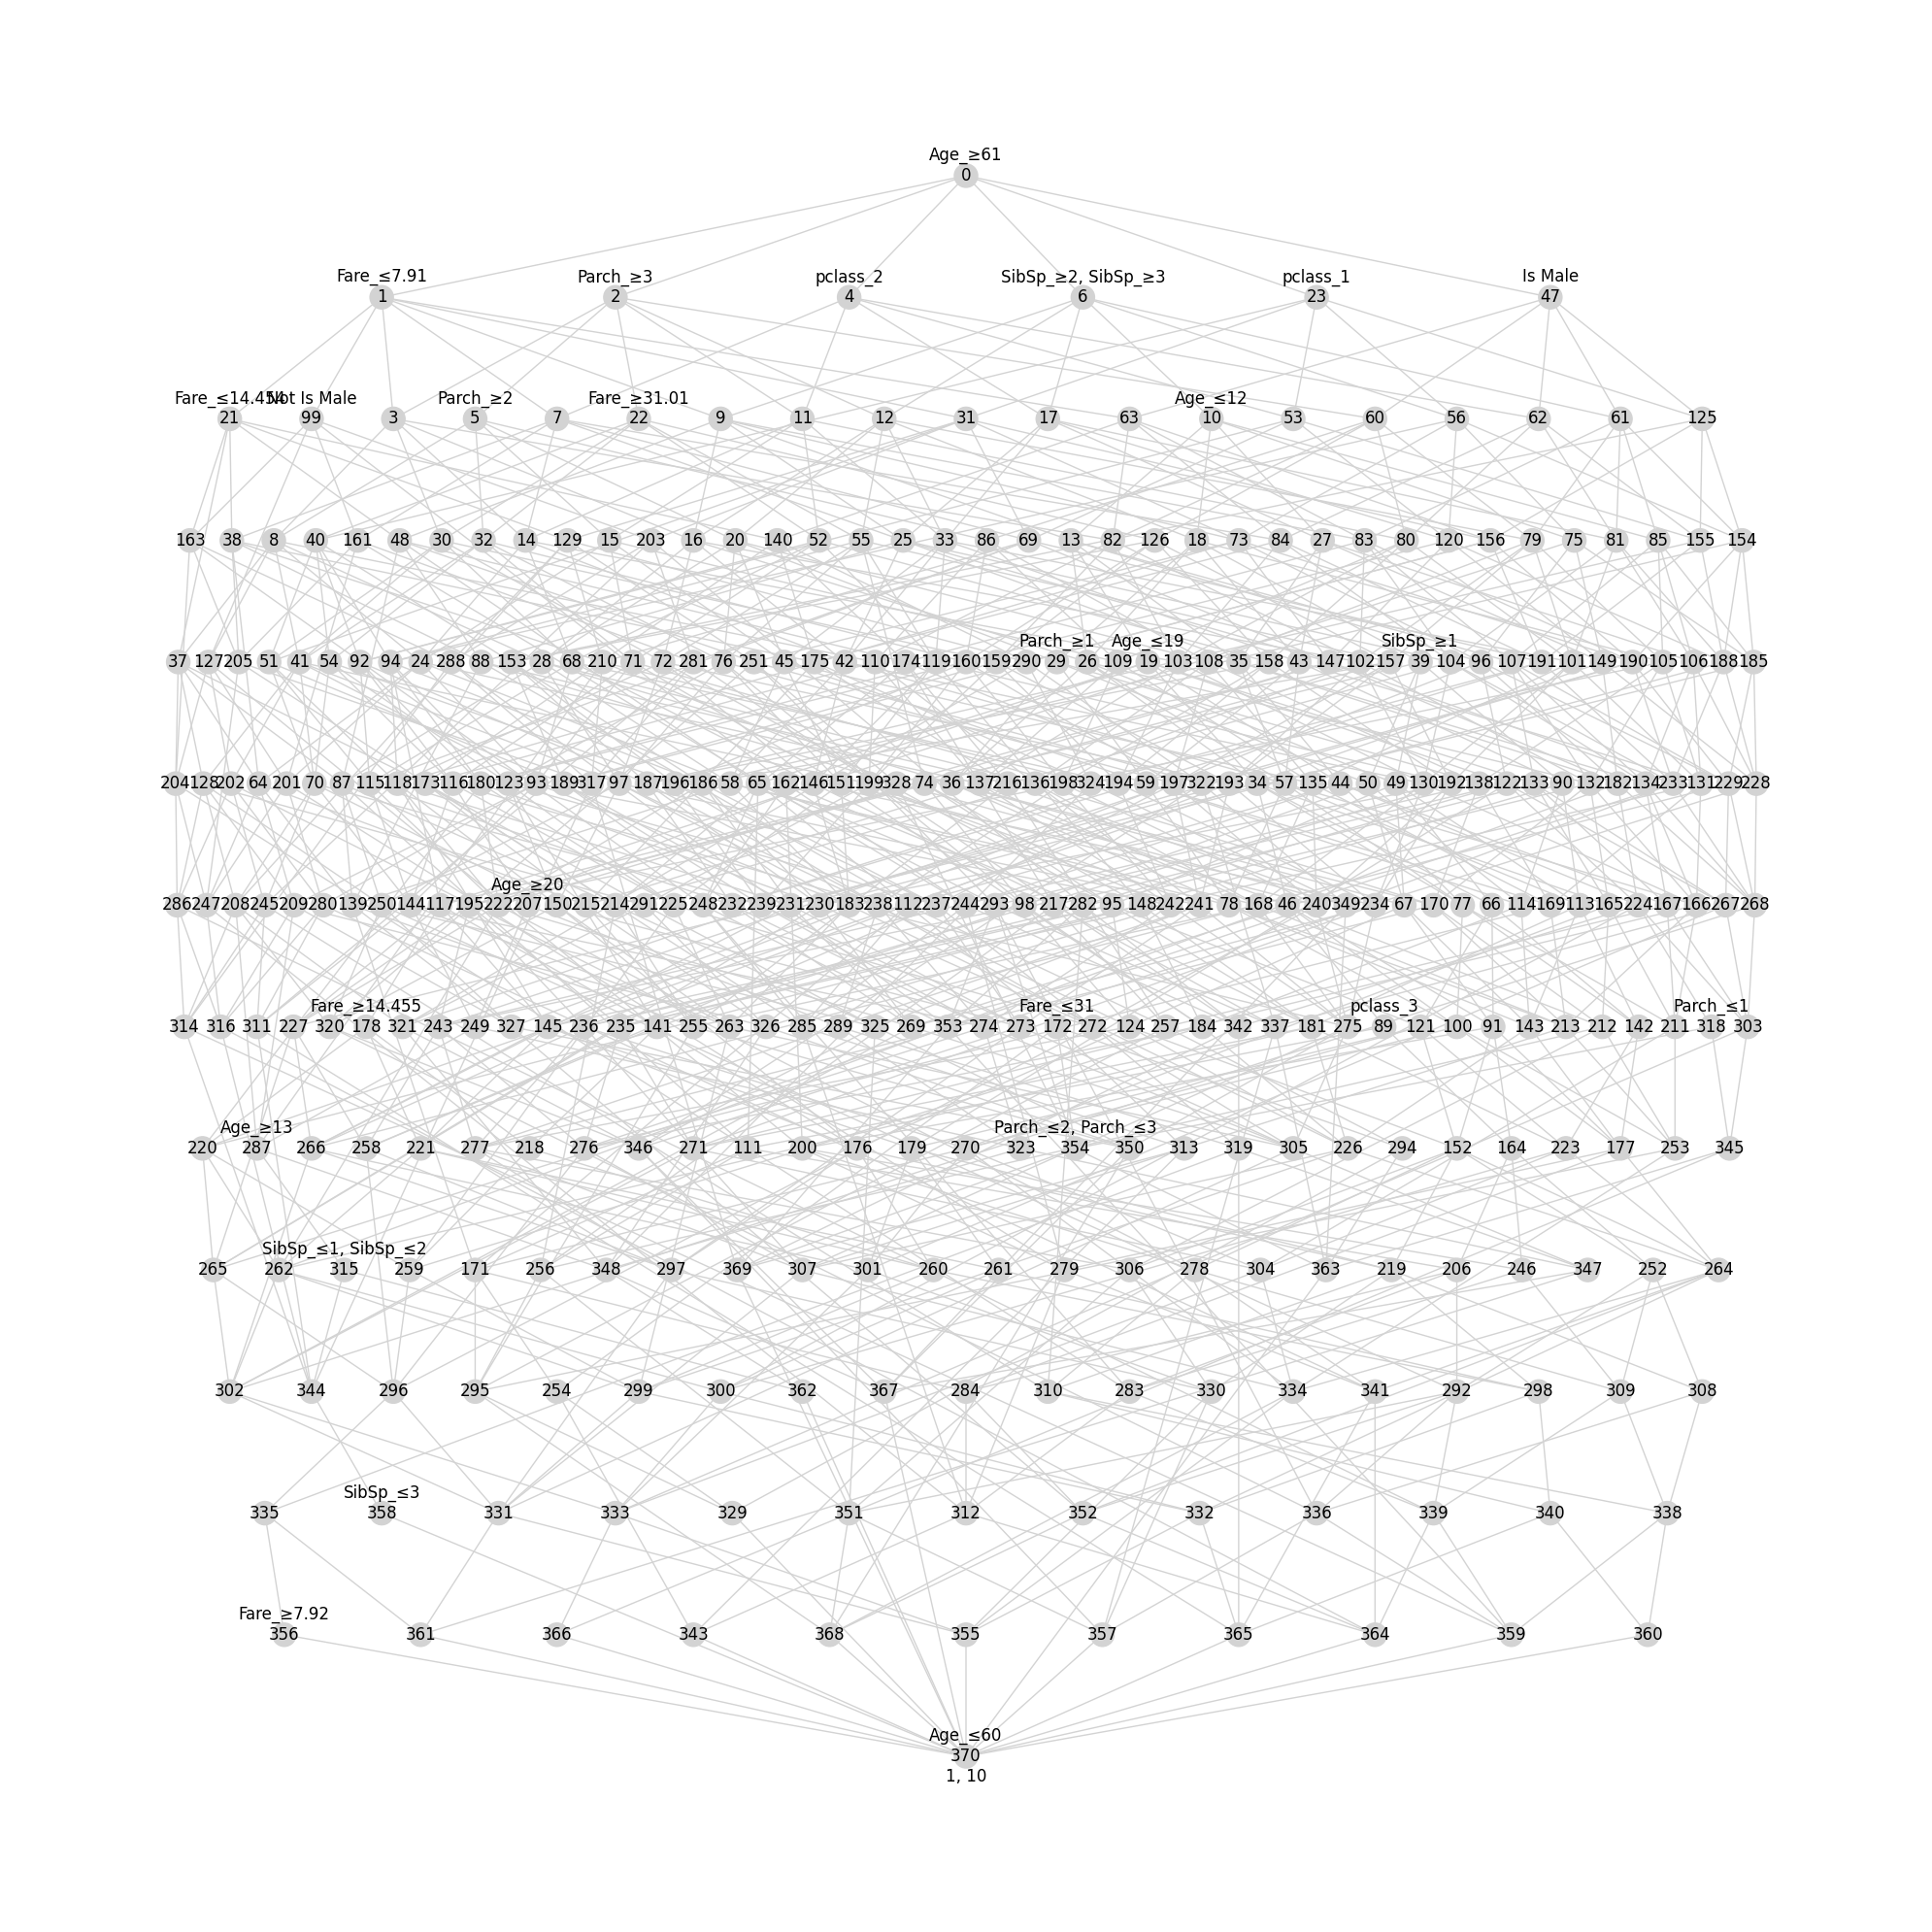

In [53]:
from fcapy.visualizer import LineVizNx
fig, ax = plt.subplots(figsize=(20,20))
vsl = LineVizNx()
vsl.draw_concept_lattice(L, ax=ax, flg_node_indices=True, flg_new_intent_count_prefix=False, flg_new_extent_count_prefix=False)

plt.tight_layout()
plt.show()

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [54]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [55]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:7])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

AssertionError: Selected concepts do not cover all train objects

Construct neural network based on concept lattice

In [56]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [57]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Now fit the network

In [58]:
cn.fit(X_train, y_train)

To obtain the prediction

In [59]:
from sklearn.metrics import accuracy_score,recall_score,f1_score
y_preds = cn.predict(X_test)[1].numpy()


print("accuracy score",accuracy_score(y_preds, y_test))
print("recall score",recall_score(y_preds, y_test))
print("f1 score",f1_score(y_preds,y_test))

accuracy score 0.8
recall score 0.5
f1 score 0.6666666666666666


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
svm_clf = SVC()
dt_clf = DecisionTreeClassifier()
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train and evaluate SVM
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")
print(f"SVM Recall: {recall_score(y_test, y_pred_svm):.2f}")
print(f"SVM F1: {f1_score(y_test, y_pred_svm):.2f}")
# Train and evaluate Decision Tree
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(f"Decision Tree Recall: {recall_score(y_test, y_pred_dt):.2f}")
print(f"Decision Tree F1: {f1_score(y_test, y_pred_dt):.2f}")

# Train and evaluate XGBoost
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"XGBoost Recall: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"XGBoost F1: {accuracy_score(y_test, y_pred_xgb):.2f}")

SVM Accuracy: 0.60
SVM Recall: 1.00
SVM F1: 0.50
Decision Tree Accuracy: 0.80
Decision Tree Recall: 1.00
Decision Tree F1: 0.67
XGBoost Accuracy: 0.80
XGBoost Recall: 0.80
XGBoost F1: 0.80


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:27:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [61]:
edge_weights = cn.edge_weights_from_network()

/usr/local/lib/python3.10/dist-packages/sparselinear/sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


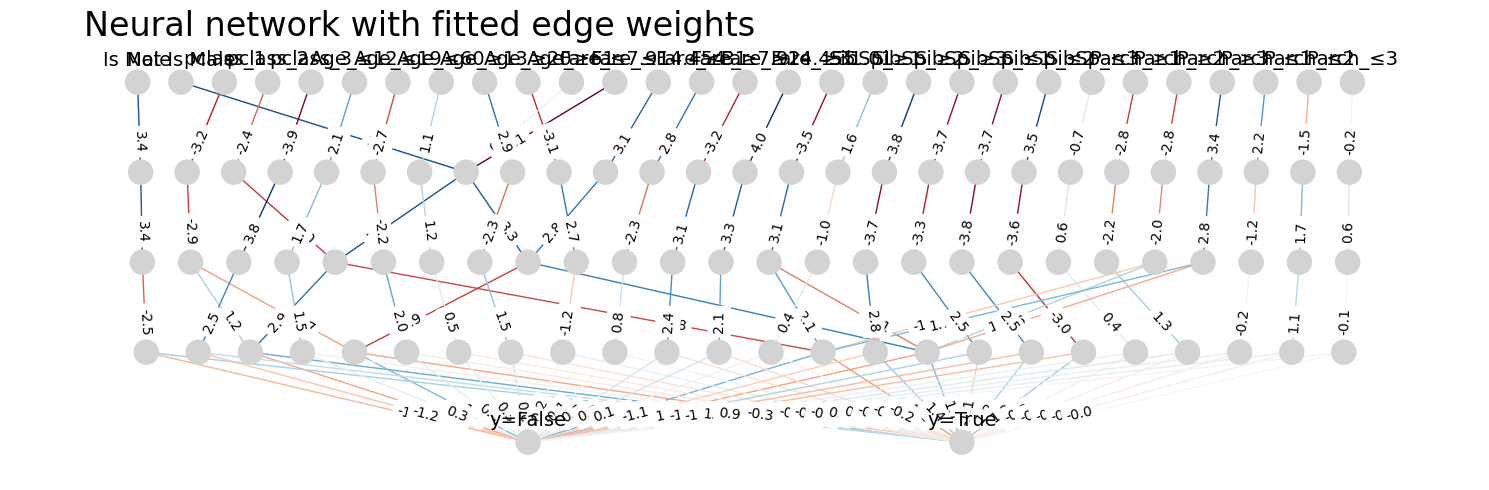

In [62]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

# Further research

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 12.8 MB/s eta 0:00:00
interval columns not set, guessing: ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']


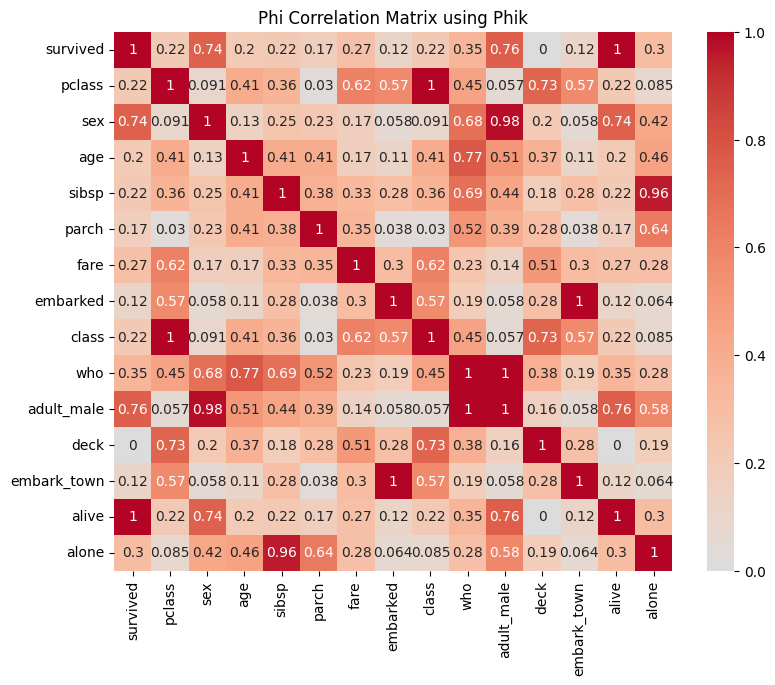

In [63]:
!pip install phik
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix


# Load the Titanic dataset
titanic = sns.load_dataset('titanic')
# Drop rows with missing values for simplicity
titanic = titanic.dropna(subset=['age', 'embarked'])
phi_corr_matrix = titanic.phik_matrix()

# Plot the correlation matrix
plt.figure(figsize=(9, 7))
sns.heatmap(phi_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Phi Correlation Matrix using Phik')
plt.show()


In [64]:
import seaborn as sns
import pandas as pd

# Load the Titanic dataset
titanic = sns.load_dataset('titanic')
# Drop rows with missing values for simplicity
titanic = titanic.dropna(subset=['age', 'embarked'])

# Dichotomic Scale for 'Sex'
titanic['Is Male'] = (titanic['sex'] == 'male').astype(int)
titanic['Not Is Male'] = (titanic['sex'] != 'male').astype(int)

# Nominal Scale for 'ticket class'
titanic = pd.get_dummies(titanic, columns=['pclass'], prefix='pclass')
titanic['Is Alone'] = (titanic['alone'] == '1').astype(int)
titanic['Not Is Alone'] = (titanic['alone'] != '0').astype(int)
titanic['Age_≤25'] = (titanic['age'] <= 25).astype(int)
titanic['Age_≥26'] = (titanic['age'] >= 26).astype(int)

# Inter-ordinal scale for Fare
titanic['Fare_≤7.91'] = (titanic['fare'] <= 7.91).astype(int)
titanic['Fare_≤14.454'] = (titanic['fare'] <= 14.454).astype(int)
titanic['Fare_≤31'] = (titanic['fare'] <= 31).astype(int)
titanic['Fare_≥7.92'] = (titanic['fare'] >= 7.92).astype(int)
titanic['Fare_≥14.455'] = (titanic['fare'] >= 14.455).astype(int)
titanic['Fare_≥31.01'] = (titanic['fare'] >= 31.01).astype(int)


#drop binarized features and not used
titanic=titanic.drop(columns=['fare','class','who','parch','adult_male','deck','embark_town','alive','alone',
                            'sex','age','sibsp','embarked' ])
titanic = titanic.astype(bool)

# Display the first few rows of the binarized dataset
print(titanic.head())


   survived  Is Male  Not Is Male  pclass_1  pclass_2  pclass_3  Is Alone  \
0     False     True        False     False     False      True     False   
1      True    False         True      True     False     False     False   
2      True    False         True     False     False      True     False   
3      True    False         True      True     False     False     False   
4     False     True        False     False     False      True     False   

   Not Is Alone  Age_≤25  Age_≥26  Fare_≤7.91  Fare_≤14.454  Fare_≤31  \
0          True     True    False        True          True      True   
1          True    False     True       False         False     False   
2          True    False     True       False          True      True   
3          True    False     True       False         False     False   
4          True    False     True       False          True      True   

   Fare_≥7.92  Fare_≥14.455  Fare_≥31.01  
0       False         False        False  
1        Tru

In [65]:
df_bin = titanic  # Skip this part as the data is already binary

In [66]:
y_feat = 'survived'

# Split the dataset into train and test sets
df_test = df_bin.sample(frac=0.2, random_state=42)  # 20% test set
df_train = df_bin.drop(df_test.index)

# Separate features and target
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]


In [67]:
# Ensure the index of X_train is of type str
X_train.index = X_train.index.astype(str)
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (570 objects, 15 attributes, 3986 connections)
   |Is Male|Not Is Male|pclass_1|pclass_2|pclass_3|...|Fare_≤14.454|Fare_≤31|Fare_≥7.92|Fare_≥14.455|Fare_≥31.01|
0  |      X|           |        |        |       X|...|           X|       X|          |            |           |
1  |       |          X|       X|        |        |...|            |        |         X|           X|          X|
3  |       |          X|       X|        |        |...|            |        |         X|           X|          X|
4  |      X|           |        |        |       X|...|           X|       X|         X|            |           |
6  |      X|           |       X|        |        |...|            |        |         X|           X|          X|
8  |       |          X|        |        |       X|...|           X|       X|         X|            |           |
9  |       |          X|        |       X|        |...|            |       X|         X|           X|           |
10 |       |          X|   

In [68]:
L = ConceptLattice.from_context(K_train, algorithm = 'Sofia', is_monotone=True) # algorithm = 'Sofia'
len(L)

447

In [69]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

In [70]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:7])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

AssertionError: Selected concepts do not cover all train objects

In [71]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [72]:
cn.fit(X_train, y_train)

In [73]:
from sklearn.metrics import accuracy_score,recall_score,f1_score
y_preds = cn.predict(X_test)[1].numpy()


print("accuracy score",accuracy_score(y_preds, y_test))
print("recall score",recall_score(y_preds, y_test))
print("f1 score",f1_score(y_preds,y_test))

accuracy score 0.7535211267605634
recall score 0.7647058823529411
f1 score 0.6902654867256637


In [74]:
edge_weights = cn.edge_weights_from_network()

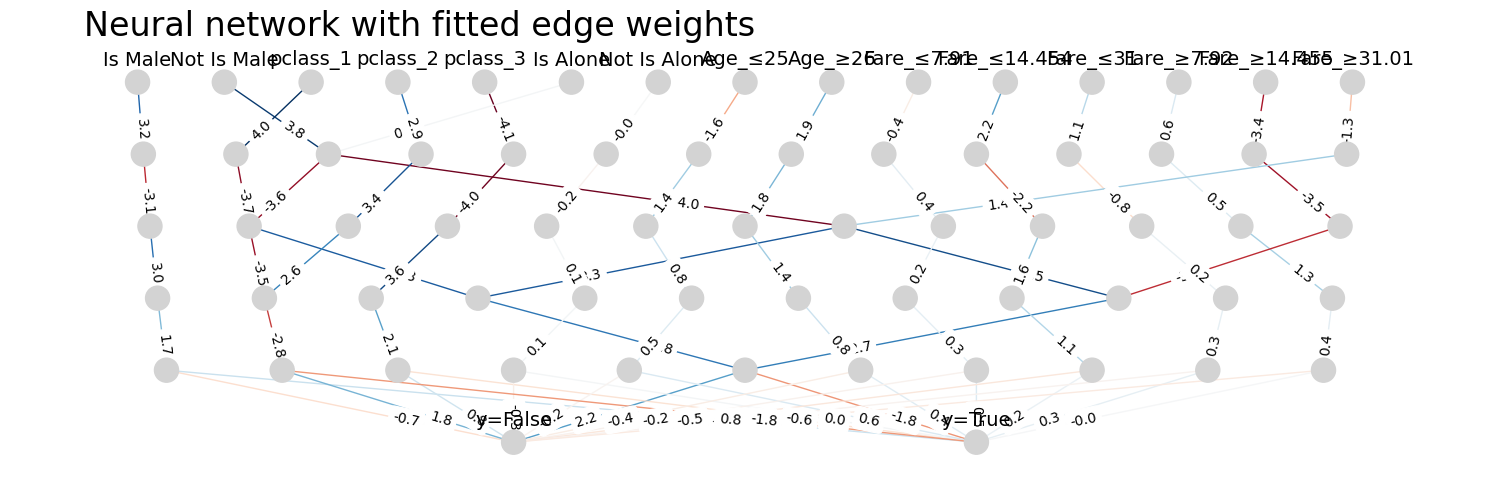

In [75]:

import networkx as nx
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(203, 217): frozenset({164}), (307, 327): frozenset({338}), (439, 442): frozenset({342})}


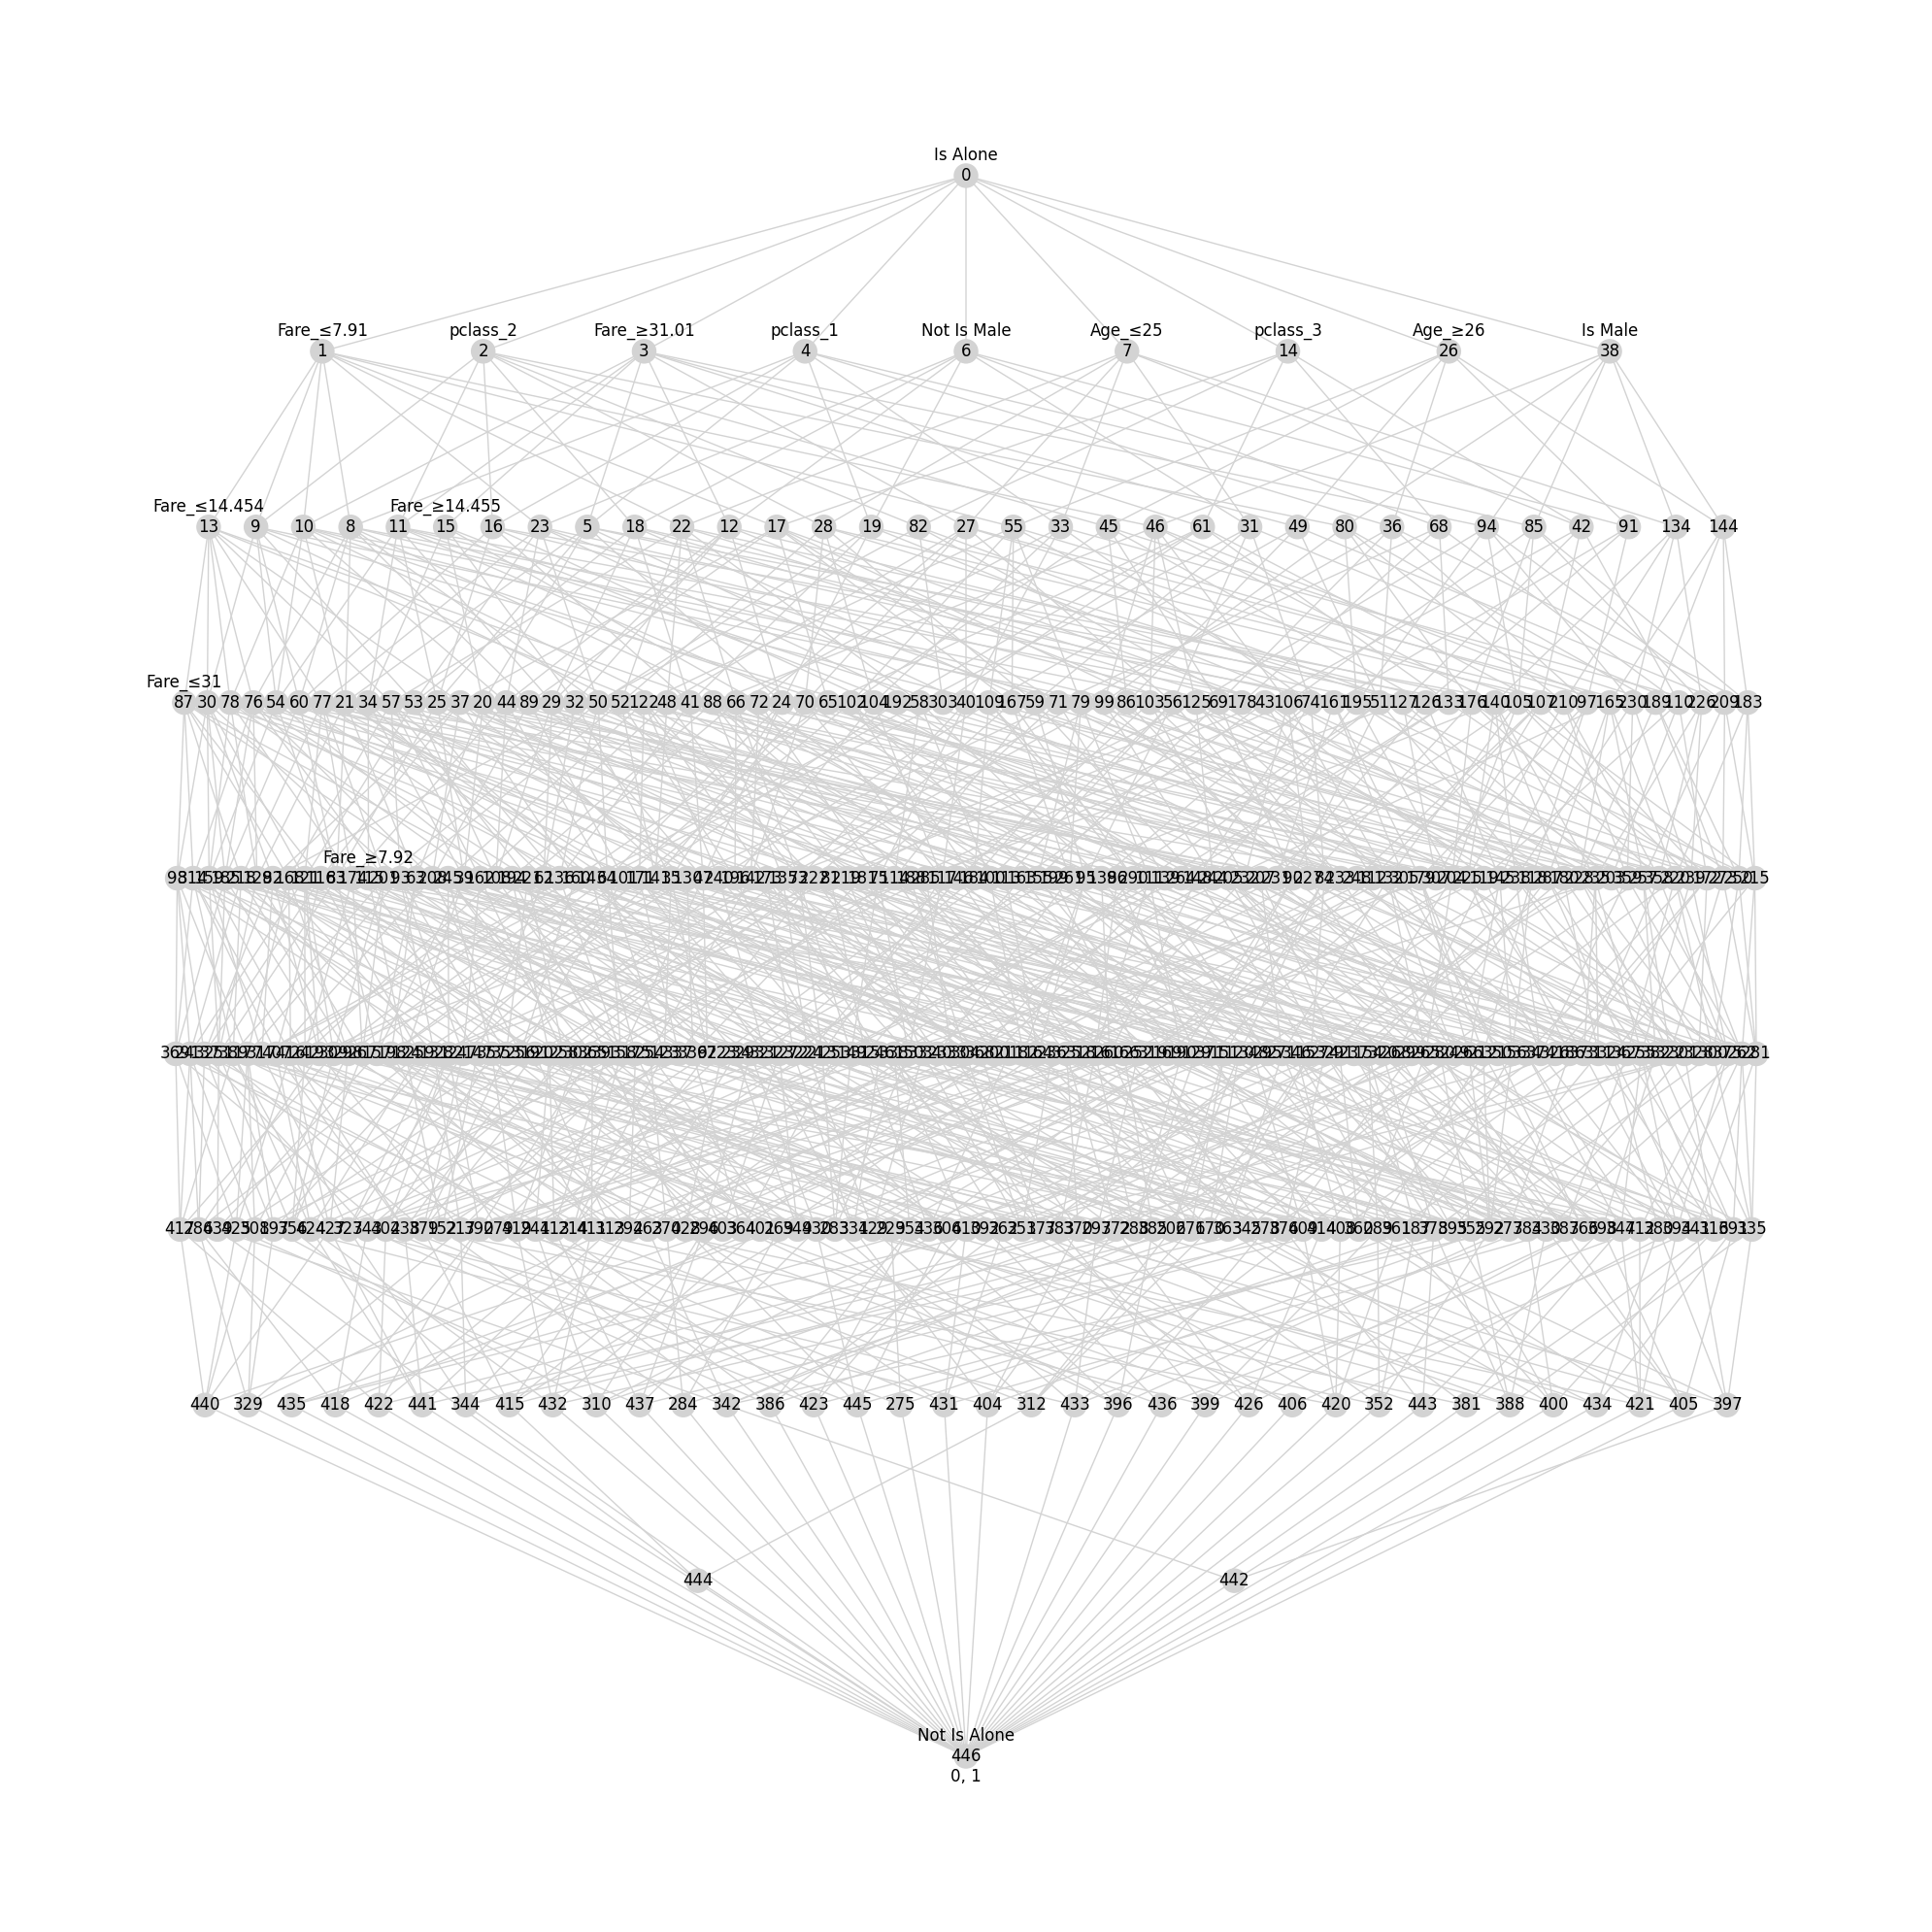

In [76]:
from fcapy.visualizer import LineVizNx
fig, ax = plt.subplots(figsize=(20,20))
vsl = LineVizNx()
vsl.draw_concept_lattice(L, ax=ax, flg_node_indices=True, flg_new_intent_count_prefix=False, flg_new_extent_count_prefix=False)

plt.tight_layout()
plt.show()

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
svm_clf = SVC()
dt_clf = DecisionTreeClassifier()
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train and evaluate SVM
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")
print(f"SVM Recall: {recall_score(y_test, y_pred_svm):.2f}")
print(f"SVM F1: {f1_score(y_test, y_pred_svm):.2f}")
# Train and evaluate Decision Tree
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(f"Decision Tree Recall: {recall_score(y_test, y_pred_dt):.2f}")
print(f"Decision Tree F1: {f1_score(y_test, y_pred_dt):.2f}")

# Train and evaluate XGBoost
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"XGBoost Recall: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"XGBoost F1: {accuracy_score(y_test, y_pred_xgb):.2f}")

SVM Accuracy: 0.78
SVM Recall: 0.53
SVM F1: 0.68
Decision Tree Accuracy: 0.77
Decision Tree Recall: 0.58
Decision Tree F1: 0.69
XGBoost Accuracy: 0.77
XGBoost Recall: 0.77
XGBoost F1: 0.77


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:29:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Lets try more best concepts

In [82]:
#tried 5,10,12,13,14
#best by 12
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:12])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

AssertionError: Selected concepts do not cover all train objects

In [83]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [84]:
cn.fit(X_train, y_train)

In [85]:
from sklearn.metrics import accuracy_score,recall_score,f1_score
y_preds = cn.predict(X_test)[1].numpy()


print("accuracy score",accuracy_score(y_preds, y_test))
print("recall score",recall_score(y_preds, y_test))
print("f1 score",f1_score(y_preds,y_test))

accuracy score 0.7535211267605634
recall score 0.7647058823529411
f1 score 0.6902654867256637
